<a href="https://colab.research.google.com/github/shaunaknn/cfd-tutorials/blob/main/OptimizationDynamicalSystems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax
import jax.numpy as np
#from jax import linear_util as lu
from jax.flatten_util import ravel_pytree
import numpy as onp
from functools import partial
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sys

In [ ]:
def Lorenz_rhs_func(state, t, ode_params):
    rho, sigma, beta = ode_params
    x, y, z = state
    return np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])

In [ ]:
# About the decorator: f is a function (not JAX array) and JAX needs to know that so we specify it as "static"
@partial(jax.jit, static_argnums=(2,))
def rk4(state, t_crt, f, ode_params):
    y_prev, t_prev = state
    h = t_crt - t_prev
    k1 = h * f(y_prev, t_prev, ode_params)
    k2 = h * f(y_prev + k1/2., t_prev + h/2., ode_params)
    k3 = h * f(y_prev + k2/2., t_prev + h/2., ode_params)
    k4 = h * f(y_prev + k3, t_prev + h, ode_params)
    y_crt = y_prev + 1./6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return (y_crt, t_crt), y_crt

In [ ]:
#ys_ = odeint(rk4, Lorenz_rhs_func, y0, ts, ode_params_opt)

#stepper is the interative solver, here it is RK4 method
#f is funcition to operate; here which is Lorenz function
#ts = np.arange(0, 101*dt, dt)
#rho, sigma, beta = ode_params
#odeint takes system function, ode parameters as input and calculates space values of the system at progressing small time difference
def odeint(stepper, f, y0, ts, ode_params):

    def stepper_partial(state, t_crt):
        #stepper function is used to advance the state of an ODE system from one time point to another. Output contains new state, new time
        return stepper(state, t_crt, f, ode_params)

    ys = []
    state = (y0, ts[0])
    for (i, t_crt) in enumerate(ts[1:]):
        state, y = stepper_partial(state, t_crt)
        #print("state, y", state, y)
        ys.append(y)
    ys = np.array(ys)
    #print("ys =", ys)
    return ys

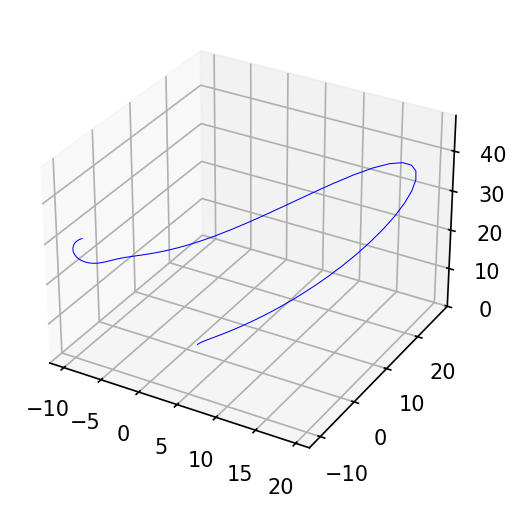

In [ ]:
#print("dumba")
y0 = np.array([1., 1., 1.])
dt = 1e-2
ts = np.arange(0, 101*dt, dt) # ts defined for optimization
#ts_plot = np.arange(0, 5001*dt, dt) # ts defined for visulization here
ode_params_gt = [28., 10., 8./3.]

ys_gt_ = odeint(rk4, Lorenz_rhs_func, y0, ts, ode_params_gt)

ys_gt = np.vstack((y0[None, ...], ys_gt_))
#ys_gt is the array consisting the states or space value over time of Lorenz System
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(projection='3d')
x0, x1, x2 = ys_gt.T
ax.plot(x0, x1, x2, lw=0.5, color='b')

In [ ]:
def compute_gradient_fd(ys, ts, obj_func, state_rhs_func, ode_params):
    print(f"running finite difference")

    y0 = ys[0]
    h = 1e-1
    ode_params_flat, unravel = ravel_pytree(ode_params)

    grads = []
    for i in range(len(ode_params_flat)):
        ode_params_flat_plus = ode_params_flat.at[i].add(h)
        ys_plus_ = odeint(rk4, state_rhs_func, y0, ts, unravel(ode_params_flat_plus))
        tau_plus = obj_func(ys_plus_[-1])

        ode_params_flat_minus = ode_params_flat.at[i].add(-h)
        ys_minus_ = odeint(rk4, state_rhs_func, y0, ts, unravel(ode_params_flat_minus))
        tau_minus = obj_func(ys_minus_[-1])

        grad = (tau_plus - tau_minus) / (2 * h)
        grads.append(grad)

    grads = unravel(np.array(grads))

    return grads

In [ ]:
def compute_gradient_ad_diff_through_loops(ys, ts, obj_func, state_rhs_func, ode_params):
    print(f"running autodiff, differentiate through loops")

    y0 = ys[0]
    def func(ode_params):
        ys_ = odeint(rk4, state_rhs_func, y0, ts, ode_params)
        return obj_func(ys_[-1])

    #jax.grad(FUNCTION) is afunction fron jax library which is used for differentiating "FUNCTION" using automatic differentiation
    grad_func = jax.grad(func)
    grads = grad_func(ode_params)

    return grads

In [ ]:
import time

def obj_func(yf, target_yf):
    return np.sum((yf - target_yf)**2)

target_yf = ys_gt_[-1]
obj_func_partial = lambda yf: obj_func(yf, target_yf)

# ode_params_0 = [np.array([26., 8., 2.])]
ode_params_0 = [26., 8., 2.]

ys_ = odeint(rk4, Lorenz_rhs_func, y0, ts, ode_params_0)
ys = np.vstack((y0[None, ...], ys_))


grads_fd = compute_gradient_fd(ys, ts, obj_func_partial, Lorenz_rhs_func, ode_params_0)
print(f"grads = {grads_fd}\n")

grads_ad_diff_through_loops = compute_gradient_ad_diff_through_loops(ys, ts, obj_func_partial, Lorenz_rhs_func, ode_params_0)
print(f"grads = {grads_ad_diff_through_loops}\n")

running finite difference
grads = [Array(-7.50198473, dtype=float64), Array(16.43200824, dtype=float64), Array(-102.63884426, dtype=float64)]

running autodiff, differentiate through loops
grads = [Array(-7.49889823, dtype=float64, weak_type=True), Array(16.43667822, dtype=float64, weak_type=True), Array(-102.74965177, dtype=float64, weak_type=True)]



In [ ]:
from numpy.matrixlib import defmatrix
from jax import config
config.update("jax_enable_x64", True)

def sum_logistic(x):
  return np.sum(1.0 / (1.0 + np.exp(-x)))

x_small = np.arange(100.)
#y_small = np.linspace(0,3,100)

derivative_fn = jax.grad(sum_logistic)  # define a function which is the gradient of sum_logistic
%timeit derivative_fn(x_small)
print(derivative_fn(x_small))

3.58 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
[2.50000000e-01 1.96611933e-01 1.04993585e-01 4.51766597e-02
 1.76627062e-02 6.64805667e-03 2.46650929e-03 9.10221180e-04
 3.35237671e-04 1.23379350e-04 4.53958077e-05 1.67011429e-05
 6.14413685e-06 2.26031919e-06 8.31527336e-07 3.05902133e-07
 1.12535149e-07 4.13993738e-08 1.52299793e-08 5.60279637e-09
 2.06115361e-09 7.58256042e-10 2.78946809e-10 1.02618796e-10
 3.77513454e-11 1.38879439e-11 5.10908903e-12 1.87952882e-12
 6.91440011e-13 2.54366565e-13 9.35762297e-14 3.44247711e-14
 1.26641655e-14 4.65888615e-15 1.71390843e-15 6.30511676e-16
 2.31952283e-16 8.53304763e-17 3.13913279e-17 1.15482242e-17
 4.24835426e-18 1.56288219e-18 5.74952226e-19 2.11513104e-19
 7.78113224e-20 2.86251858e-20 1.05306174e-20 3.87399763e-21
 1.42516408e-21 5.24288566e-22 1.92874985e-22 7.09547416e-23
 2.61027907e-23 9.60268005e-24 3.53262857e-24 1.29958143e-24
 4.78089288e-25 1.75879220e-25 6.47023493e-26 2.38026641e-26
 8.75651076e-2

In [ ]:
def first_finite_differences(f, x):
  eps = 1e-6
  return np.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in np.eye(len(x))])

%timeit first_finite_differences(sum_logistic, x_small)
print(first_finite_differences(sum_logistic, x_small))

40.2 ms ± 988 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
[2.49999999e-01 1.96611936e-01 1.04993582e-01 4.51766553e-02
 1.76627069e-02 6.64805100e-03 2.46650700e-03 9.10219455e-04
 3.35241168e-04 1.23378641e-04 4.53965754e-05 1.66977543e-05
 6.14619466e-06 2.25952590e-06 8.31335001e-07 3.05533376e-07
 1.13686838e-07 4.26325641e-08 1.42108547e-08 7.10542736e-09
 7.10542736e-09 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00

In [ ]:
## optimize(ode_params_0, y0, ts, obj_func_partial, Lorenz_rhs_func, bounds, compute_gradient_fd)

def optimize(ode_params_0, y0, ts, obj_func, state_rhs_func, bounds, compute_gradient_func):
    x_ini, unravel = ravel_pytree(ode_params_0)
    obj_vals = []

    def objective(x):
        print(f"\n######################### Evaluating objective value - step {objective.counter}")
        x = np.array(x)
        ode_params = unravel(x)
        ys_ = odeint(rk4, state_rhs_func, y0, ts, ode_params)
        ys = np.vstack((y0[None, ...], ys_))
        obj_val = obj_func(ys[-1])

        objective.ode_params = ode_params
        objective.ys = ys
        objective.x = ode_params

        objective.counter += 1
        obj_vals.append(obj_val)

        print(f"obj_val = {obj_val}")
        print(f"ode_params = {ode_params}")
        print(f"ys[-1] = {ys[-1]}")

        return obj_val

    def derivative(x):
        ode_params = objective.ode_params
        ys = objective.ys

        grads = compute_gradient_func(ys, ts, obj_func, state_rhs_func, ode_params)
        print(f"########################################################")
        print(f"grads = {grads}")
        print(f"########################################################")

        grads_ravelled, _ = ravel_pytree(grads)
        # 'L-BFGS-B' requires the following conversion, otherwise we get an error message saying
        # -- input not fortran contiguous -- expected elsize=8 but got 4
        return onp.array(grads_ravelled, order='F', dtype=onp.float64)

    objective.counter = 0
    options = {'maxiter': 1000, 'disp': True}  # CG or L-BFGS-B or Newton-CG or SLSQP
    res = opt.minimize(fun=objective,
                       x0=x_ini,
                       method='SLSQP',
                       jac=derivative,
                       bounds=bounds,
                       callback=None,
                       options=options)

    return objective.x

In [ ]:
#just some arrays containing two variables, probably x, y space value, let's see

bounds = np.array([[26., 30.], [8., 12.], [8./3., 8./3.]])

#calling the main optimizing function, let's go to optimize function, it takes 7 input arguments


ode_params_opt = optimize(ode_params_0, y0, ts, obj_func_partial, Lorenz_rhs_func, bounds, compute_gradient_fd)



#optimized ode paramaters derived from optimize function would be an inpur argument of odeint function

ys_ = odeint(rk4, Lorenz_rhs_func, y0, ts, ode_params_opt)

print(f"\nGround truth parameter values = {ode_params_gt}")
print(f"Ground truth yf = {target_yf}")
print(f"\nInitial parameter values = {ode_params_0}")
print(f"Optimized parameter values = {ode_params_opt}")
print(f"Optimized yf = {ys_[-1]}")


######################### Evaluating objective value - step 0
obj_val = 4.860940360033302
ode_params = [Array(26., dtype=float64), Array(8., dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-10.52796043 -10.17111714  28.86326064]
running finite difference
########################################################
grads = [Array(-6.92302198, dtype=float64), Array(-5.14942014, dtype=float64), Array(18.96071564, dtype=float64)]
########################################################

######################### Evaluating objective value - step 1
obj_val = 4.410150407239057
ode_params = [Array(30., dtype=float64), Array(12., dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-9.98216602 -9.483049   31.02914495]

######################### Evaluating objective value - step 2
obj_val = 4.529462931818786e-05
ode_params = [Array(28.01884614, dtype=float64), Array(10.01884614, dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-9.3760406  -8.36218938 29.36591828]
runn

In [ ]:
#just some arrays containing two variables, probably x, y space value, let's see

bounds = np.array([[26., 30.], [8., 12.], [8./3., 8./3.]])

#calling the main optimizing function, let's go to optimize function, it takes 7 input arguments


ode_params_opt = optimize(ode_params_0, y0, ts, obj_func_partial, Lorenz_rhs_func, bounds, compute_gradient_ad_diff_through_loops)



#optimized ode paramaters derived from optimize function would be an inpur argument of odeint function

ys_ = odeint(rk4, Lorenz_rhs_func, y0, ts, ode_params_opt)

print(f"\nGround truth parameter values = {ode_params_gt}")
print(f"Ground truth yf = {target_yf}")
print(f"\nInitial parameter values = {ode_params_0}")
print(f"Optimized parameter values = {ode_params_opt}")
print(f"Optimized yf = {ys_[-1]}")


######################### Evaluating objective value - step 0
obj_val = 4.860940360033302
ode_params = [Array(26., dtype=float64), Array(8., dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-10.52796043 -10.17111714  28.86326064]
running autodiff, differentiate through loops
########################################################
grads = [Array(-6.91298703, dtype=float64), Array(-5.13073221, dtype=float64), Array(19.05073521, dtype=float64)]
########################################################

######################### Evaluating objective value - step 1
obj_val = 4.410150407239115
ode_params = [Array(30., dtype=float64), Array(12., dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-9.98216602 -9.483049   31.02914495]

######################### Evaluating objective value - step 2
obj_val = 4.551618339862518e-05
ode_params = [Array(28.01889151, dtype=float64), Array(10.01889151, dtype=float64), Array(2.66666667, dtype=float64)]
ys[-1] = [-9.37603464 -8.362202